In [146]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt

from assistive_arm.utils.plotting import plot_knee_coordinates, plot_mocap_forces
from assistive_arm.utils.data_preprocessing import prepare_mocap_data, prepare_opencap_markers, prepare_mocap_force_df, read_headers, export_filtered_force, sync_mocap_with_opencap, transform_force_coordinates
from assistive_arm.utils.file_modification import modify_force_xml

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read data

In [147]:
subject = "subject_4"
subject_data = Path("/Users/xabieririzar/Desktop/Life/Studium/TUM/M.Sc Robotics/Harvard/Thesis/Subject testing/Subject data/") / subject
project_moco_data = Path("/Users/xabieririzar/uni-projects/Harvard/assistive-arm/moco/")

# Set directories
trial = subject_data / "trial_3"
figures_path = trial / "Plots"

if not os.path.exists(figures_path):
    os.makedirs(figures_path)

right_foot = trial / "mocap_f_20.tsv"
left_foot = trial / "mocap_f_21.tsv"

sides_plates = {"r": right_foot, "l": left_foot}

if int(subject[-1]) > 1:
    right_foot = trial / "mocap_f_16.tsv"
    left_foot = trial / "mocap_f_17.tsv"
    chair_force = trial / "mocap_f_20.tsv"
    sides_plates = {"r": right_foot, "l": left_foot, "chair": chair_force}


In [148]:
modify_force_xml('../moco/forces/grf_sit_stand.xml', str(trial / "grf_filtered.mot"))

In [149]:
# Read force data
mocap_forces = {}

for side, plate in sides_plates.items():
    # It must always be in this order
    col_names = [
        f"ground_force_{side}_vx",
        f"ground_force_{side}_vy",
        f"ground_force_{side}_vz",
        f"ground_force_{side}_px",
        f"ground_force_{side}_py",
        f"ground_force_{side}_pz",
        f"ground_torque_{side}_x",
        f"ground_torque_{side}_y",
        f"ground_torque_{side}_z",
        "nan"]
    mocap_forces[side] = {"headers": None, "data": None}
    headers = read_headers(plate, 25)
    mocap_forces[side]["headers"] = headers[9:21]
    mocap_forces[side]["data"] = pd.read_csv(
        plate, 
        delimiter="\t", 
        skiprows=26, 
        names=[f"ground_force_{side}_vx", f"ground_force_{side}_vy", f"ground_force_{side}_vz", f"ground_torque_{side}_x", f"ground_torque_{side}_y", f"ground_torque_{side}_z", f"ground_force_{side}_px", f"ground_force_{side}_py", f"ground_force_{side}_pz", "nan"])
    mocap_forces[side]["data"] = mocap_forces[side]["data"].reindex(columns=col_names)
print("FP Frequency: ", headers[1][1])

# Read mocap marker data
mocap_headers = read_headers(trial / "mocap_markers.tsv", 10)
mocap_headers = {header[0]: header[1:] for header in mocap_headers}
print("Marker frequency: ", mocap_headers["FREQUENCY"][0])
mocap_marker_names = mocap_headers["MARKER_NAMES"] # Read row 10 and get marker names
mocap_markers_unsynced = pd.read_csv(trial / "mocap_markers.tsv", delimiter="\t", skiprows=11)

# Read opencap marker data
headers = read_headers(trial / "opencap_tracker.trc", 3)
print("Opencap frequency: ", headers[2][1])
opencap_markers_unsynced = pd.read_csv(trial / "opencap_tracker.trc", delimiter="\t", skiprows=3).tail(-1)


if int(mocap_headers["FREQUENCY"][0]) > int(float(headers[2][1])):
    print(f"Downsampling to Opencap frequency {headers[2][1]}")
    mocap_markers_unsynced = mocap_markers_unsynced[::2]
    mocap_markers_unsynced.reset_index(drop=True, inplace=True)
    for side in mocap_forces:
        mocap_forces[side]["data"] = mocap_forces[side]["data"][::2]
        mocap_forces[side]["data"].reset_index(drop=True, inplace=True)

FP Frequency:  1200
Marker frequency:  120
Opencap frequency:  60.0
Downsampling to Opencap frequency 60.0


## Process data

In [150]:
# Prepare mocap data
mocap_markers_unsynced = prepare_mocap_data(df=mocap_markers_unsynced, marker_names=mocap_marker_names)
opencap_markers_unsynced = prepare_opencap_markers(opencap_markers_unsynced)
mocap_forces_in_world_frame = prepare_mocap_force_df(force_plate_data=mocap_forces, forces_in_world=True)

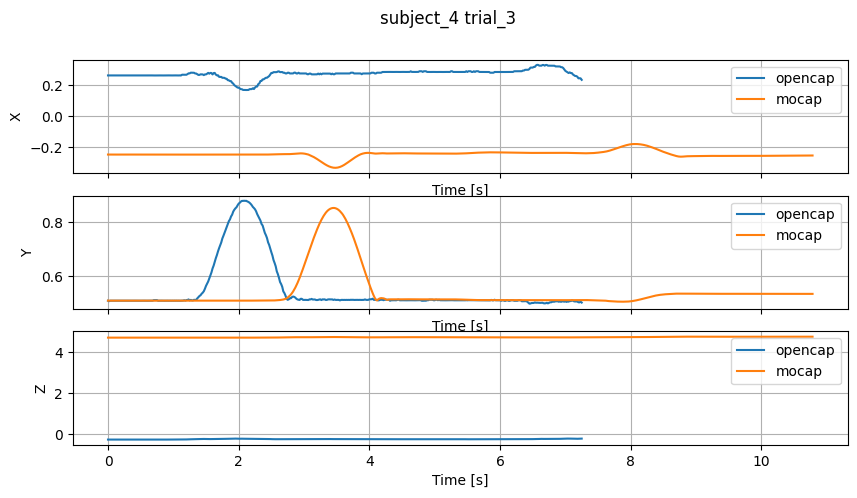

In [151]:
plot_knee_coordinates(opencap_markers=opencap_markers_unsynced, mocap_markers=mocap_markers_unsynced, subject=subject, trial=trial.stem, output_path=figures_path / "opencap_mocap_markers.png")

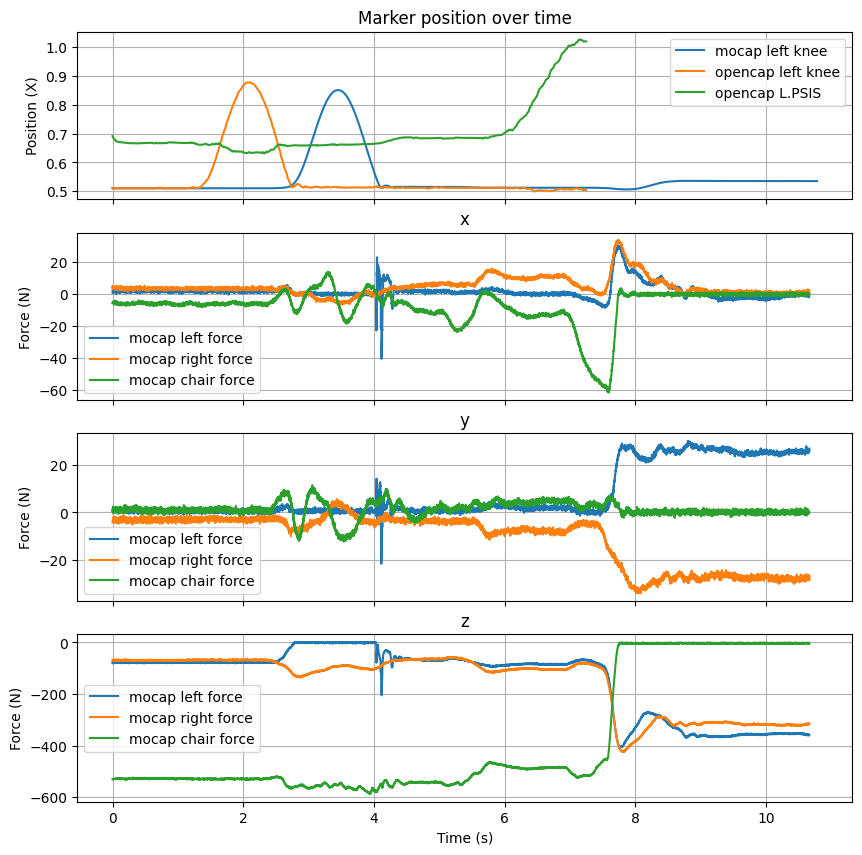

In [152]:
plot_mocap_forces(opencap_markers=opencap_markers_unsynced, mocap_markers=mocap_markers_unsynced, mocap_forces=mocap_forces_in_world_frame, force_plates=sides_plates, output_path=figures_path / "unfiltered")

In [153]:
opencap_origin = mocap_markers_unsynced.Origin.mean(axis=0)
mocap_forces_in_opencap_frame = transform_force_coordinates(force_trial=mocap_forces_in_world_frame, new_origin=opencap_origin, plates=sides_plates)
mocap_markers_synced, mocap_forces_in_opencap_frame, opencap_markers_synced, lag, standup_index = sync_mocap_with_opencap(mocap_data=mocap_markers_unsynced, force_data=mocap_forces_in_opencap_frame, opencap_data=opencap_markers_unsynced)

Lag:  -82


In [174]:
offset = 0.5 # seconds
motion_beginning = (int(standup_index / 10) - int(0.5 / (1/float(headers[2][1])))) * 10

print(f"Lift off from chair at {round(mocap_forces_in_opencap_frame.time.iloc[standup_index], 3)}s")
print(f"Setting start of movement {offset}s before lift off")

print(f"Beginning at {round(mocap_forces_in_opencap_frame.time.iloc[motion_beginning], 3)}s")


Lift off from chair at 6.387s
Setting start of movement 0.5s before lift off
Beginning at 5.883s


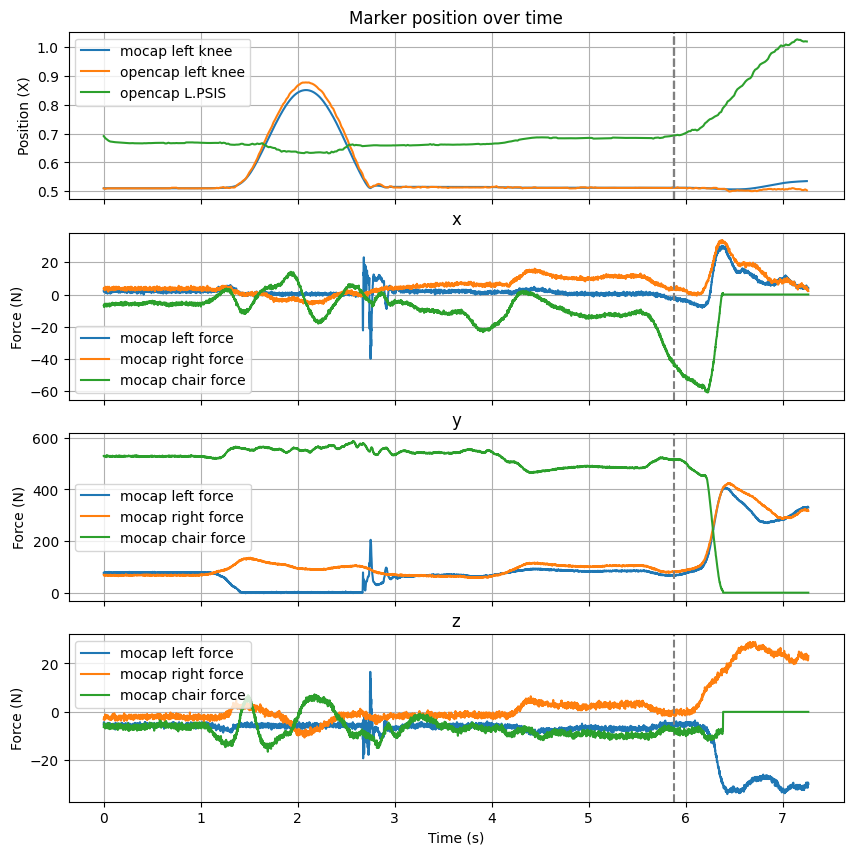

In [167]:
plot_mocap_forces(opencap_markers=opencap_markers_synced, mocap_markers=mocap_markers_synced, mocap_forces=mocap_forces_in_opencap_frame, force_plates=sides_plates, motion_beginning=motion_beginning, output_path=figures_path / "filtered_marker_forces.png")

In [ ]:
# Set center of pressure to 0 to ensure that the force is applied exactly at the pelvis
mocap_forces_in_opencap_frame.ground_force_chair_px *= 0
mocap_forces_in_opencap_frame.ground_force_chair_py *= 0
mocap_forces_in_opencap_frame.ground_force_chair_pz *= 0

In [ ]:
export_filtered_force(mocap_forces_in_opencap_frame, trial / f"grf_filtered.mot")

Writing to  /Users/xabieririzar/Desktop/Life/Studium/TUM/M.Sc Robotics/Harvard/Thesis/Subject testing/Subject data/subject_4/trial_3/grf_filtered.mot
